In [1]:
from efficientnet_pytorch import EfficientNet

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from fastai.script import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastprogress import fastprogress
from torchvision.models import *

In [4]:
model = EfficientNet.from_name('efficientnet-b5')

In [5]:
model_name = 'efficientnet-b5'
image_size = EfficientNet.get_image_size(model_name)

In [6]:
image_size

456

In [7]:
model = EfficientNet.from_pretrained(model_name)


Loaded pretrained weights for efficientnet-b5


In [8]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [9]:
np.random.seed(13)


In [10]:
src = (ImageList.from_folder(path='train-snakes-cropped').split_by_rand_pct(0.2).label_from_folder())

In [11]:
tfms=([rotate(degrees=(-90,90), p=0.8)],[])

In [12]:
bs=8

In [13]:
data = (src.transform(tfms, size=image_size, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=bs).normalize(imagenet_stats))

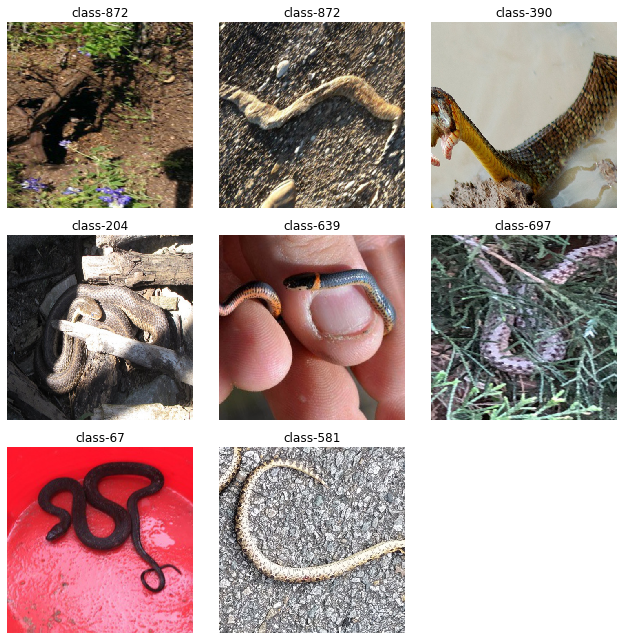

In [14]:
data.show_batch(3,figsize=(9,9))

In [15]:
list(children(model))[-2:]


[BatchNorm2d(2048, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True),
 Linear(in_features=2048, out_features=1000, bias=True)]

In [16]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [17]:
model.add_module('_fc',nn.Linear(2048, data.c))

In [18]:
loss_func =LabelSmoothingCrossEntropy()


In [19]:
RMSprop = partial(torch.optim.RMSprop)


In [20]:
from torch.optim import Optimizer

In [21]:
learn = Learner(data, model, loss_func=loss_func, opt_func=RMSprop, metrics=[accuracy,FBeta(beta=1,average='macro')])


learn

learn.model

learn.split([[learn.model._conv_stem, learn.model._bn0, learn.model._blocks[:19]],
             [learn.model._blocks[19:],learn.model._conv_head], 
             [learn.model._bn1,learn.model._fc]])

learn.summary()

learn.load('b5-seed-13-round-1')

Learner(data=ImageDataBunch;

Train: LabelList (65932 items)
x: ImageList
Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
y: CategoryList
class-857,class-857,class-857,class-857,class-857
Path: train-snakes-cropped;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
y: CategoryList
class-204,class-639,class-337,class-508,class-771
Path: train-snakes-cropped;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_

In [22]:
learn.lr_find(wd=1e-4)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


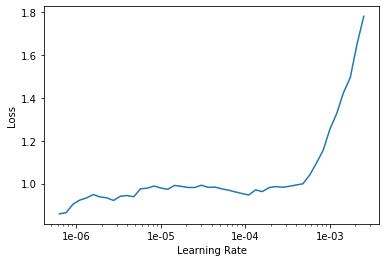

In [23]:
learn.recorder.plot()

In [25]:
lr=5e-5

In [26]:
learn.fit_one_cycle(2,max_lr=slice(lr/100,lr),final_div=1e3,wd=1e-4)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.962916,1.097440,0.865316,0.837002,47:50
1,0.916326,1.095579,0.867136,0.839736,47:57


In [27]:
learn.save('b5-seed-13-round-2')

In [28]:
lr=1e-5

In [29]:
learn.fit_one_cycle(2,max_lr=slice(lr/100,lr),final_div=1e3,wd=1e-4)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.903659,1.096180,0.866590,0.838670,47:52
1,0.941700,1.094059,0.867075,0.839957,47:57


In [30]:
learn.save('b5-seed-13-round-3')

In [31]:
preds,_ = learn.TTA(ds_type=DatasetType.Valid)

In [32]:
probs = np.exp(preds)/np.exp(preds).sum(1)[:,None]

In [33]:
probs_np = probs.numpy()

In [34]:
y_pred = []
for i in range(0,len(data.valid_ds.y.items)):
    temp = np.asarray(probs_np[i,:])
    y_pred.append(np.argmax(temp))

In [35]:
y_true = data.valid_ds.y.items

In [36]:
import sklearn.metrics

In [37]:
sklearn.metrics.accuracy_score(y_true,y_pred)

0.8758114420918522

In [38]:
sklearn.metrics.f1_score(y_true,y_pred,average='macro')

0.8529604198313425

In [40]:
learn.validate()

[1.0940592, tensor(0.8671), tensor(0.8411)]

In [41]:
preds,_ = learn.TTA(ds_type=DatasetType.Test)

AttributeError: 'NoneType' object has no attribute 'dataset'

In [ ]:
probs = np.exp(preds)/np.exp(preds).sum(1)[:,None]

In [ ]:
probs_np = probs.numpy()

In [ ]:
df_test = pd.read_csv('test_file.csv',low_memory=False)

In [ ]:
df_test.head()

In [ ]:
data.classes[np.argmax(probs[0])]

In [ ]:
df_classes = pd.read_csv('class.csv',low_memory=False)

In [ ]:
df_classes.head()

In [ ]:
data_dict = df_classes.set_index('class_idx')['original_class'].to_dict()

In [ ]:
data_dict

In [ ]:
data.test_ds.items

In [ ]:
print(os.path.basename(data.test_ds.items[0]))

In [ ]:
df_test.head()

In [ ]:
probs_np = probs.numpy()

In [ ]:
df_testfile_mapping = pd.DataFrame(columns=['filename','map'])

In [ ]:
df_testfile_mapping['filename']=df_test['filename']

In [ ]:
for i,row in df_testfile_mapping.iterrows():
    row['map']=i

In [ ]:
df_testfile_mapping.head()

In [ ]:
data_dict_filename = df_testfile_mapping.set_index('filename')['map'].to_dict()

In [ ]:
i = 0
for test_file in data.test_ds.items:
    filename = (os.path.basename(test_file))
    map_val = int(data_dict_filename[filename])    
    for c in range(0,45):
        df_test.loc[map_val,data_dict[int(data.classes[c].split("-")[1])]]=probs_np[i][c]
    i += 1
    print(i)

In [ ]:
df_test.to_csv('submission-b2.csv',index=False)

In [ ]:
for i,row in df_test.iterrows():
    sum_temp=row[1:46].sum()
    low_limit = 1-1e-6
    high_limit = 1+1e-6
    print(sum_temp)
    assert sum_temp>= low_limit and sum_temp <= high_limit

In [ ]:
df_to_save =pd.DataFrame(probs_np)
df_to_save.to_csv('test-b2.csv',header=header,index=False)

In [ ]:
df_final = pd.read_csv('submission-b2.csv',low_memory=False)

In [ ]:
df_final.head()

In [ ]:
for i,row in df_final.iterrows():
    sum_temp=row[1:46].sum()
    low_limit = 1-1e-6
    high_limit = 1+1e-6
    if not (sum_temp>= low_limit and sum_temp <= high_limit):
        print(i)
        print(sum_temp)

In [ ]:
for i,row in df_final.iterrows():
    probs = np.asarray(row[1:46])
    print(i)
    index_val = np.argmax(probs)
    for c in range(1,46):
        df_final.iloc[i,c]=0.44/44 #handles precision error , we set 0.01 to false classes, 0.56 to predicted class
    df_final.iloc[i,index_val+1]=0.56

In [ ]:
for i,row in df.iterrows():
    sum_temp=row[1:46].sum()
    low_limit = 1-1e-6
    high_limit = 1+1e-6
    assert sum_temp>= low_limit and sum_temp <= high_limit

In [ ]:
for i,row in df_final.iterrows():
    probs = np.asarray(row[1:46])
    print(i)
    index_val = np.argmax(probs)
    for c in range(1,46):
        df_final.iloc[i,c]=0
    df_final.iloc[i,index_val+1]=1